In [1]:
%load_ext autoreload
%autoreload 2 
#pip install beautifulsoup4
#pip install plotly

In [2]:
import os
import pandas as pd
import gzip
import shutil
import requests
import numpy as np
from datetime import datetime, timedelta

import StormData
import Compare

from bs4 import BeautifulSoup

import Dataloader as DL
import ReAnalysisData as rad
import ensemble_pn

import Lmodel as model1
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
df_master_X = pd.read_pickle("df_master_X.pkl").dropna()
# _dfm_diff = pd.read_pickle("_dfm_diff.pkl")

In [4]:
NUM_OF_INTERVALS = 21
master = df_master_X[df_master_X.index.get_level_values('date').year < 2023]
master_2023 = df_master_X[df_master_X.index.get_level_values('date').year >= 2023]

In [5]:
# total number of storms
master.groupby([master.index.get_level_values('date').year, 'CY']).apply(lambda group: group.index.tolist())

date  CY
2008  02                                                                                                                                                               [(2008-07-03 12:00:00, AL, 02), (2008-07-03 18:00:00, AL, 02), (2008-07-04 00:00:00, AL, 02), (2008-07-08 06:00:00, AL, 02), (2008-07-08 12:00:00, AL, 02), (2008-07-08 18:00:00, AL, 02), (2008-07-09 00:00:00, AL, 02), (2008-07-09 06:00:00, AL, 02), (2008-07-09 12:00:00, AL, 02), (2008-07-09 18:00:00, AL, 02), (2008-07-10 00:00:00, AL, 02), (2008-07-10 06:00:00, AL, 02), (2008-07-10 12:00:00, AL, 02), (2008-07-10 18:00:00, AL, 02), (2008-07-11 00:00:00, AL, 02), (2008-07-11 06:00:00, AL, 02), (2008-07-11 12:00:00, AL, 02), (2008-07-11 18:00:00, AL, 02), (2008-07-12 12:00:00, AL, 02), (2008-07-12 18:00:00, AL, 02), (2008-07-13 00:00:00, AL, 02), (2008-07-13 18:00:00, AL, 02), (2008-07-14 06:00:00, AL, 02), (2008-07-14 12:00:00, AL, 02), (2008-07-14 18:00:00, AL, 02), (2008-07-15 06:00:00, AL, 02), (2008-07-15 12:00

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = master

# Sort the DataFrame based on index
df = df.sort_index()

# Use groupby to group by index levels and create lists of indices for each group
grouped_indices = df.groupby([df.index.get_level_values('date').year, 'CY']).apply(lambda group: group.index.tolist())

# Split the indices into train and test sets
train_indices, test_indices = train_test_split(grouped_indices, test_size=0.1, random_state=500)

# Create train and test DataFrames based on the selected indices
train_df = df.loc[pd.Index(idx for indices in train_indices for idx in indices)]
test_df = df.loc[pd.Index(idx for indices in test_indices for idx in indices)]

# Reset the index for the new DataFrames
train_df = train_df.reset_index().drop_duplicates().reset_index(drop=True)
test_df = test_df.reset_index().drop_duplicates().reset_index(drop=True)

# Set 'date', 'basin', and 'CY' as index for both DataFrames
train = train_df.set_index(['date', 'basin', 'CY'])
test = df #test_df.set_index(['date', 'basin', 'CY'])

In [7]:
from joblib import dump, load
X1 = train.iloc[:, :-NUM_OF_INTERVALS*2].to_numpy().astype(np.float64)
y1 = train.iloc[:, -NUM_OF_INTERVALS*2:].to_numpy().astype(np.float64)

'''
mod = model1.kfold_model(X1, y1, num_folds=5, max_epochs = 50, intervals = NUM_OF_INTERVALS)
dump(mod, 'mod_five_0-1_500__3.joblib')
'''

mod = load('mod_five_0-1_500__3.joblib') 

In [8]:
X_test = test.iloc[:, :-NUM_OF_INTERVALS*2].to_numpy().astype(np.float64)
y_test = test.iloc[:, -NUM_OF_INTERVALS*2:].to_numpy().astype(np.float64)

In [9]:
import torch.nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#mod.to(device)
#mod.eval()
mod.double()  # Set the model to Double data type
X_test = torch.tensor(X_test, dtype=torch.double).unsqueeze(1).to(device)

In [10]:
mod

CNN(
  (fc1): Linear(in_features=924, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=42, bias=True)
  (relu): ReLU()
)

In [11]:
outputs = mod(X_test).detach().numpy()
outputs

array([[ 12.81029935, -23.08462597,  12.84000862, ..., -52.99941484,
         20.49757575, -54.43377719],
       [ 13.10563476, -24.71665761,  13.20874561, ..., -55.60724399,
         20.91830168, -57.12386448],
       [ 14.08527636, -26.41595199,  13.97956163, ..., -56.60357967,
         21.68592661, -58.3008513 ],
       ...,
       [ 18.22701254, -81.56663926,  18.48741057, ..., -84.33410159,
         30.68649212, -83.92775258],
       [ 19.49255545, -82.34875163,  19.81698343, ..., -83.28974603,
         31.13482789, -82.77314959],
       [ 23.18081381, -67.06473017,  23.3704019 , ..., -86.00062341,
         27.358711  , -86.67267349]])

In [12]:
_cols = []
for i in range(0, NUM_OF_INTERVALS):
    lat = 'PREDLAT'+ str(i*6).zfill(2)
    lon = 'PREDLON'+ str(i*6).zfill(2)
    _cols.append(lat)
    _cols.append(lon)

In [13]:
df_output = pd.DataFrame(data = outputs, columns = _cols)
test_reset = test.reset_index()
df_output_reset = df_output.reset_index()

# Concatenate DataFrames along columns axis
full_matrix = pd.concat([test_reset, df_output_reset], axis=1)
full_matrix.set_index(['date', 'basin', 'CY'], inplace=True)
full_matrix.drop(['index'], axis=1, inplace=True)

In [14]:
full_matrix

AC00lat00  AC00lat06  AC00lat12  AC00lat18  \
date                basin CY                                               
2008-07-03 12:00:00 AL    02       12.3       12.8       12.9       13.3   
2008-07-03 18:00:00 AL    02       12.7       13.0       13.4       14.0   
2008-07-04 00:00:00 AL    02       13.1       13.8       14.1       14.6   
2008-07-08 06:00:00 AL    02       20.0       20.3       20.8       21.4   
2008-07-08 12:00:00 AL    02       20.7       21.0       21.6       21.8   
...                                 ...        ...        ...        ...   
2022-09-25 18:00:00 AL    09       15.0       15.8       16.6       17.4   
2022-09-26 00:00:00 AL    09       15.7       16.7       17.6       18.6   
2022-09-26 06:00:00 AL    09       16.8       17.5       18.6       19.6   
2022-09-26 12:00:00 AL    09       17.8       18.6       19.7       20.7   
2022-11-06 18:00:00 AL    17       20.8       22.7       23.8       25.0   

                              AC00lat24  AC00lat30  AC00lat36  AC00lat42  \
date                basin CY                                               
2008-07-03 12:00:00 AL    02       13.9       14.2       15.0       15.3   
2008-07-03 18:00:00 AL    02       14.0       14.9       15.2       15.6   
2008-07-04 00:00:00 AL    02       15.1       15.7       16.0       16.4   
2008-07-08 06:00:00 AL    02       21.8       22.2       22.7       23.0   
2008-07-08 12:00:00 AL    02       22.5       23.0       23.2       24.0   
...                                 ...        ...        ...        ...   
2022-09-25 18:00:00 AL    09       18.2       19.4       20.4       21.3   
2022-09-26 00:00:00 AL    09       19.8       20.8       21.7       22.8   
2022-09-26 06:00:00 AL    09       20.6       21.6       22.5       23.4   
2022-09-26 12:00:00 AL    09       22.0       22.8       23.7       24.6   
2022-11-06 18:00:00 AL    17       24.4       25.3       26.5       27.5   

                              AC00lat48  AC00lat54  AC00lat60  AC00lat66  \
date                basin CY                                               
2008-07-03 12:00:00 AL    02       15.7       16.3       16.9       17.5   
2008-07-03 18:00:00 AL    02       16.0       16.2       16.8       16.9   
2008-07-04 00:00:00 AL    02       16.8       16.9       17.2       17.7   
2008-07-08 06:00:00 AL    02       23.5       24.5       24.2       24.2   
2008-07-08 12:00:00 AL    02       24.1       25.2       25.8       26.2   
...                                 ...        ...        ...        ...   
2022-09-25 18:00:00 AL    09       22.4       23.4       24.4       25.3   
2022-09-26 00:00:00 AL    09       23.7       24.6       25.5       26.3   
2022-09-26 06:00:00 AL    09       24.3       25.1       25.9       26.5   
2022-09-26 12:00:00 AL    09       25.3       26.2       26.7       27.2   
2022-11-06 18:00:00 AL    17       28.2       28.3       28.1       27.3   

                              AC00lat72  AC00lat78  AC00lat84  AC00lat90  \
date                basin CY                                               
2008-07-03 12:00:00 AL    02       17.7       18.0       18.8       19.1   
2008-07-03 18:00:00 AL    02       17.8       17.8       18.3       18.9   
2008-07-04 00:00:00 AL    02       18.2       18.7       19.0       19.8   
2008-07-08 06:00:00 AL    02       24.2       24.2       24.2       24.2   
2008-07-08 12:00:00 AL    02       26.2       26.9       28.1       28.2   
...                                 ...        ...        ...        ...   
2022-09-25 18:00:00 AL    09       26.2       27.0       27.6       28.1   
2022-09-26 00:00:00 AL    09       27.1       27.5       27.7       28.1   
2022-09-26 06:00:00 AL    09       27.0       27.3       27.7       28.3   
2022-09-26 12:00:00 AL    09       27.3       27.8       27.9       28.4   
2022-11-06 18:00:00 AL    17       26.6       26.3       26.7       26.9   

                              AC00lat96  AC00lat102  AC00lat108  AC00lat11

In [15]:
from geopy.distance import geodesic
from haversine import haversine, Unit
import math

count = []
mod_dists = []
ens_dists = []
for i in range (0, NUM_OF_INTERVALS):
    tau = str(i*6).zfill(2)
    best = ['BESTLAT' + tau, 'BESTLON' + tau]
    mean = ['AEMNlat' + tau, 'AEMNlon' + tau]
    pred = ['PREDLAT' + tau, 'PREDLON' + tau]
    
    best_coords = full_matrix[best].to_records(index=False)
    mean_coords = full_matrix[mean].to_records(index=False)
    pred_coords = full_matrix[pred].to_records(index=False)
    
    distances = []
    mod_dist = []
    ens_dist = []
    for j in range(len(best_coords)):
        ens_mean_dist = haversine(best_coords[j], mean_coords[j], unit=Unit.KILOMETERS)
        model_dist = haversine(best_coords[j], pred_coords[j], unit=Unit.KILOMETERS)
        
        mod_dist.append(model_dist)
        ens_dist.append(ens_mean_dist)
        
        if (ens_mean_dist > model_dist):
            distances.append(1)
        else:
            distances.append(-1)
            
    count.append(distances)
    mod_dists.append(mod_dist)
    ens_dists.append(ens_dist)

In [16]:
np.mean(mod_dists)

235.87474638270075

In [17]:
np.mean(ens_dists)

257.5272914419489

In [18]:
[np.mean(mod_dists) - np.mean(ens_dists)] / np.mean(ens_dists)

array([-0.08407864])

In [19]:
df_mod_dists = pd.DataFrame(data = mod_dists).T
df_mod_dists.columns = df_mod_dists.columns.astype(int) * 6

df_ens_dists = pd.DataFrame(data = ens_dists).T
df_ens_dists.columns = df_ens_dists.columns.astype(int) * 6

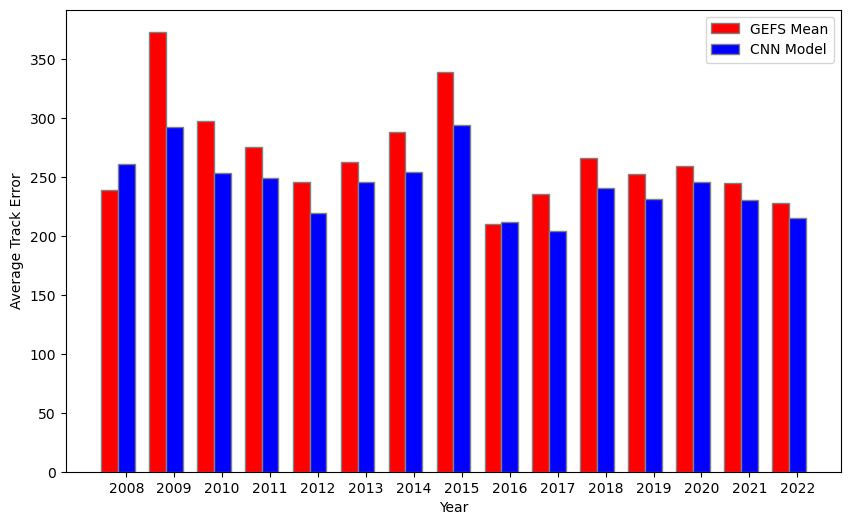

In [20]:
df_mod_dists.set_index(full_matrix.index, inplace=True)
df_mod_avg_year = pd.DataFrame(df_mod_dists.groupby(df_mod_dists.index.get_level_values('date').year).mean().mean(axis=1)
                              ).rename(index = {"date": "Year"}, columns = {0: "CNN Average Track Error"})

df_ens_dists.set_index(full_matrix.index, inplace=True)
df_ens_avg_year = pd.DataFrame(df_ens_dists.groupby(df_ens_dists.index.get_level_values('date').year).mean().mean(axis=1)
                              ).rename(index = {"date": "Year"}, columns = {0: "GEFS Mean Average Track Error"})

merged_df = df_mod_avg_year.join(df_ens_avg_year)

# Plotting
plt.figure(figsize=(10, 6))

# Set position of bar on X axis
bar_width = 0.35
r1 = range(len(merged_df))

# Make the plot
plt.bar(r1, merged_df['GEFS Mean Average Track Error'], color='r', width=bar_width, edgecolor='grey', label='GEFS Mean')
plt.bar([x + bar_width for x in r1], merged_df['CNN Average Track Error'], color='b', width=bar_width, edgecolor='grey', label='CNN Model')

# Adding labels
plt.xlabel('Year')
plt.ylabel('Average Track Error')
plt.xticks([r + bar_width for r in range(len(merged_df))], merged_df.index)

# Adding legend
plt.legend()

# Show plot
plt.show()

In [21]:
# precent of 5-day forecasts improved
df_mod_sum = df_mod_dists.mean(axis=1)
df_ens_sum = df_ens_dists.mean(axis=1)
(df_mod_sum < df_ens_sum).sum() / len(df_mod_sum < df_ens_sum)

0.5824634655532359

In [22]:
statistics = pd.DataFrame()

statistics['mod_mse'] = (df_mod_dists**2).sum(axis=0)/len(df_mod_dists)
statistics['ens_mse'] = (df_ens_dists**2).sum(axis=0)/len(df_ens_dists)

statistics['mod_rmse'] = statistics['mod_mse'] ** 0.5
statistics['ens_rmse'] = statistics['ens_mse'] ** 0.5

statistics['mod_mae'] = df_mod_dists.sum(axis=0)/len(df_mod_dists)
statistics['ens_mae'] = df_ens_dists.sum(axis=0)/len(df_ens_dists)

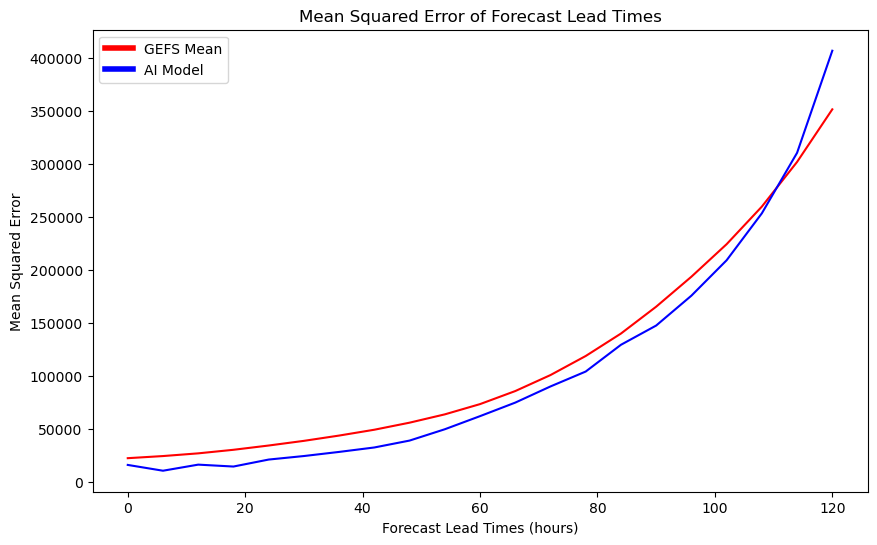

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the DataFrame to have a single 'Value' column for seaborn
df_melted = pd.melt(statistics.reset_index(), id_vars=['index'], value_vars=['ens_mse', 'mod_mse'], var_name='Column', value_name='Value')

# Define custom colors for the bars
custom_colors = {'ens_mse': 'red', 'mod_mse': 'blue'}

# Plotting the double bar graph using seaborn with custom colors
plt.figure(figsize=(10, 6))
sns.lineplot(x='index', y='Value', hue='Column', data=df_melted, palette=custom_colors)

# Adding labels, title, and legend
plt.xlabel('Forecast Lead Times (hours)')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error of Forecast Lead Times')

# Provide legend labels and handles directly
legend_labels = ['GEFS Mean', 'AI Model']
legend_handles = [plt.Line2D([0], [0], color=custom_colors[key], lw=4) for key in custom_colors]
plt.legend(legend_handles, legend_labels)

# Show the plot
plt.show()

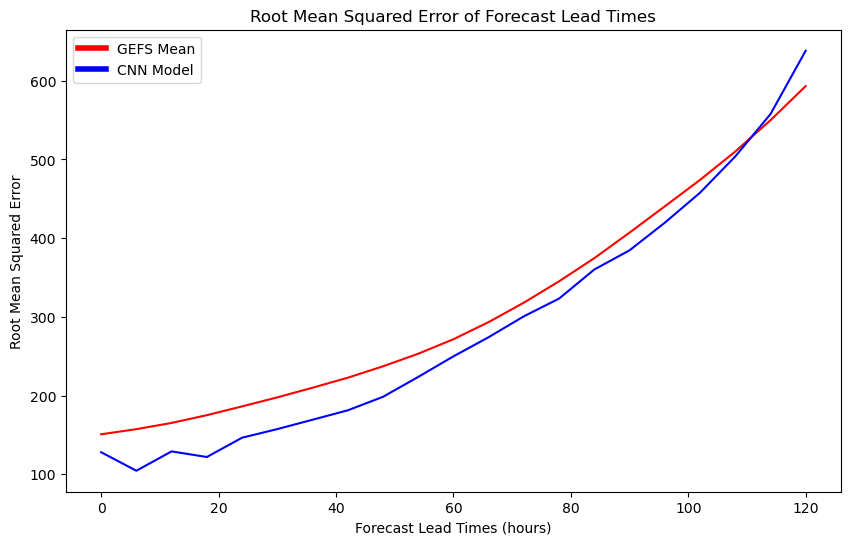

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'statistics' is your DataFrame

# Melt the DataFrame to have a single 'Value' column for seaborn
df_melted = pd.melt(statistics.reset_index(), id_vars=['index'], value_vars=['ens_rmse', 'mod_rmse'], var_name='Column', value_name='Value')

# Define custom colors for the bars
custom_colors = {'ens_rmse': 'red', 'mod_rmse': 'blue'}

# Plotting the double bar graph using seaborn with custom colors
plt.figure(figsize=(10, 6))
sns.lineplot(x='index', y='Value', hue='Column', data=df_melted, palette=custom_colors)

# Adding labels, title, and legend
plt.xlabel('Forecast Lead Times (hours)')
plt.ylabel('Root Mean Squared Error')
plt.title('Root Mean Squared Error of Forecast Lead Times')

# Provide legend labels and handles directly
legend_labels = ['GEFS Mean', 'CNN Model']
legend_handles = [plt.Line2D([0], [0], color=custom_colors[key], lw=4) for key in custom_colors]
plt.legend(legend_handles, legend_labels)

# Show the plot
plt.show()

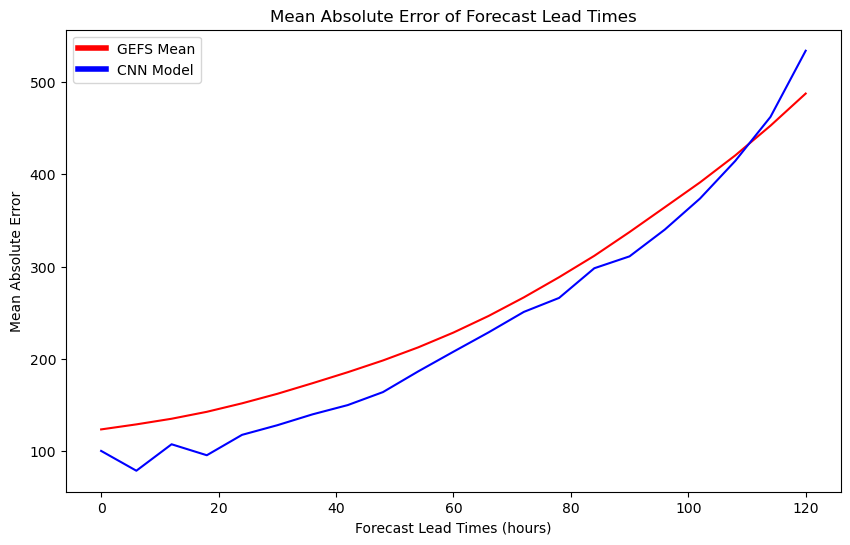

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'statistics' is your DataFrame

# Melt the DataFrame to have a single 'Value' column for seaborn
df_melted = pd.melt(statistics.reset_index(), id_vars=['index'], value_vars=['ens_mae', 'mod_mae'], var_name='Column', value_name='Value')

# Define custom colors for the bars
custom_colors = {'ens_mae': 'red', 'mod_mae': 'blue'}

# Plotting the double bar graph using seaborn with custom colors
plt.figure(figsize=(10, 6))
sns.lineplot(x='index', y='Value', hue='Column', data=df_melted, palette=custom_colors)

# Adding labels, title, and legend
plt.xlabel('Forecast Lead Times (hours)')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error of Forecast Lead Times')

# Provide legend labels and handles directly
legend_labels = ['GEFS Mean', 'CNN Model']
legend_handles = [plt.Line2D([0], [0], color=custom_colors[key], lw=4) for key in custom_colors]
plt.legend(legend_handles, legend_labels)

# Show the plot
plt.show()

In [26]:
df_mod_dists.describe()

0            6            12           18           24   \
count  2395.000000  2395.000000  2395.000000  2395.000000  2395.000000   
mean    100.118297    78.631903   107.311290    95.415486   117.521621   
std      79.974365    69.042398    71.940857    76.102925    87.572971   
min       1.784644     1.368962     2.551718     2.033775     5.760879   
25%      52.038696    44.104280    67.413744    51.847178    63.793118   
50%      83.818700    68.323369    99.726846    81.242750   100.171489   
75%     130.233058    96.470982   133.820483   122.285604   151.649799   
max    1602.684279  1652.317238  1656.942832  1693.893498  1711.640817   

               30           36           42           48           54   \
count  2395.000000  2395.000000  2395.000000  2395.000000  2395.000000   
mean    127.951724   139.736320   149.784053   163.871602   186.311012   
std      91.835793    95.728441   102.206798   111.948034   123.900654   
min       1.640125     3.288236     3.796597     2.829286     0.698528   
25%      69.304291    77.263938    81.279213    88.649618   102.498796   
50%     110.153649   122.870435   129.564358   143.101323   161.274475   
75%     165.783268   178.629035   190.812648   208.068097   237.258170   
max    1705.504748  1718.468779  1671.674745  1623.720188  1645.071566   

               60           66           72           78           84   \
count  2395.000000  2395.000000  2395.000000  2395.000000  2395.000000   
mean    207.649417   228.659388   250.826884   265.981350   298.161523   
std     138.977210   151.385436   165.946368   183.758654   202.087532   
min       4.126512     1.588180     4.440394     2.041344     6.260840   
25%     114.303949   128.958603   142.189499   139.445475   162.168825   
50%     179.819317   197.983436   221.366210   229.197784   253.503360   
75%     262.488719   286.712089   312.954017   335.843849   382.362167   
max    1579.404659  1547.954609  1494.326897  1513.442352  1985.076528   

               90           96           102          108          114  \
count  2395.000000  2395.000000  2395.000000  2395.000000  2395.000000   
mean    311.042477   340.037432   373.708988   414.451066   462.206439   
std     226.167418   245.881170   264.244152   286.327926   311.754851   
min       5.208878     5.280230     9.264321     2.500893     0.992838   
25%     154.563880   172.591179   193.391531   213.033331   245.682780   
50%     261.521856   281.689942   313.622244   350.725737   392.075865   
75%     398.579153   439.406247   482.126833   533.944679   593.450403   
max    2433.820387  2702.379327  2849.889628  2846.303339  2860.925478   

               120  
count  2395.000000  
mean    533.991400  
std     349.274617  
min       4.186817  
25%     289.290103  
50%     460.019623  
75%     694.388638  
max    2829.172721

In [27]:
df_mod_dist_std = df_mod_dists - df_mod_dists.describe().loc['std']

In [28]:
df_ens_dists.describe()

0            6            12           18           24   \
count  2395.000000  2395.000000  2395.000000  2395.000000  2395.000000   
mean    123.424960   128.879341   134.982625   142.504438   151.703968   
std      86.864948    90.407996    95.460513   101.905571   108.205717   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      75.877187    77.539599    78.389336    79.606608    85.071962   
50%     115.368947   117.365120   120.875062   125.198796   131.984779   
75%     157.439882   164.832406   171.504081   181.196928   196.188877   
max    1700.124683  1772.622306  1846.075977  1962.613557  2047.049793   

               30           36           42           48           54   \
count  2395.000000  2395.000000  2395.000000  2395.000000  2395.000000   
mean    162.009364   173.512318   185.423066   198.167855   212.365818   
std     113.476927   118.348113   123.458352   130.413040   137.887526   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      87.824649    93.633470   101.177017   106.211756   115.235779   
50%     140.787166   151.565609   164.644881   178.166685   191.277448   
75%     211.245334   227.581533   242.454630   259.286623   280.320851   
max    2067.679729  2036.050938  1969.841220  1923.332246  1888.071469   

               60           66           72           78           84   \
count  2395.000000  2395.000000  2395.000000  2395.000000  2395.000000   
mean    228.405465   246.454723   266.579918   288.441016   311.640446   
std     147.018942   159.230064   173.552837   189.671375   207.889352   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%     124.142807   133.434096   144.645759   156.059350   167.680267   
50%     204.809348   220.100773   234.758428   253.146167   271.212484   
75%     299.155263   321.950537   345.187525   375.396447   406.515534   
max    1869.817024  1826.309184  1776.338184  1793.615916  2114.199239   

               90           96           102          108          114  \
count  2395.000000  2395.000000  2395.000000  2395.000000  2395.000000   
mean    337.398840   364.259575   391.218949   420.465794   452.679578   
std     227.683802   247.535003   267.567308   288.621481   311.962443   
min       0.000000    11.119508     0.000000     9.817943    10.604863   
25%     179.053062   195.187498   206.435529   218.960271   235.098237   
50%     292.571090   314.093519   337.313363   360.695845   388.705278   
75%     433.883002   470.125880   505.306782   544.745867   588.306293   
max    2529.731754  2778.128780  2923.411165  2854.204741  2736.445226   

               120  
count  2395.000000  
mean    487.555062  
std     337.852233  
min       8.145516  
25%     249.002906  
50%     417.729310  
75%     636.085017  
max    2970.194338

In [29]:
df_ens_dist_std = df_ens_dists - df_ens_dists.describe().loc['std']

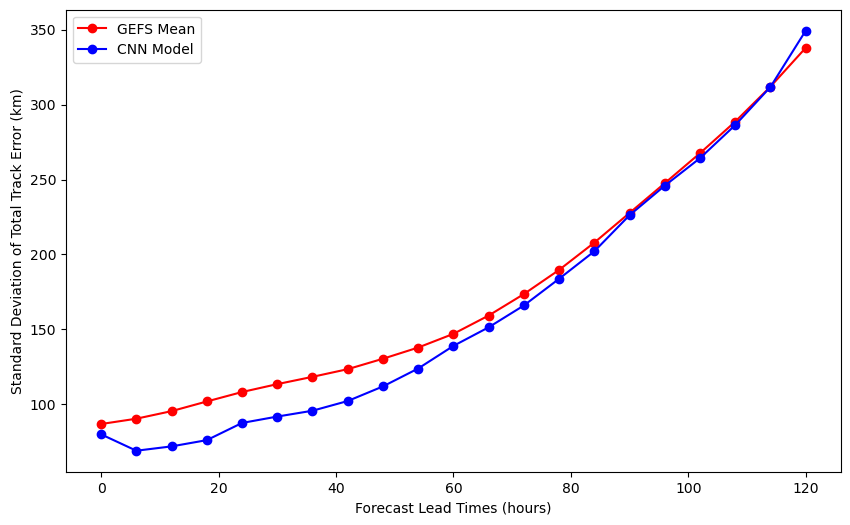

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the lines
plt.plot(df_ens_dists.describe().loc['std'], color='red', label='GEFS Mean', marker='o')
plt.plot(df_mod_dists.describe().loc['std'], color='blue', label='CNN Model', marker='o')

# Add labels and legend
plt.xlabel('Forecast Lead Times (hours)')
plt.ylabel('Standard Deviation of Total Track Error (km)')
plt.legend(loc = 'upper left')

# Show the plot
plt.show()

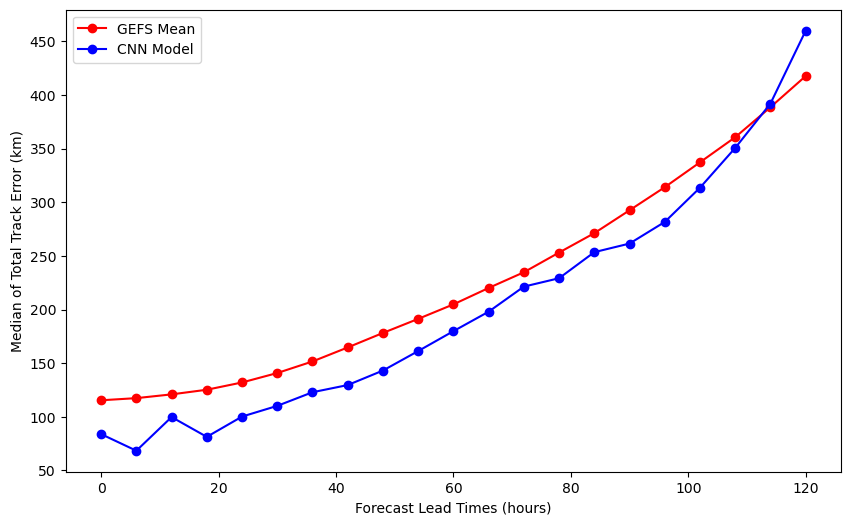

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the lines
plt.plot(df_ens_dists.describe().loc['50%'], color='red', label='GEFS Mean', marker='o')
plt.plot(df_mod_dists.describe().loc['50%'], color='blue', label='CNN Model', marker='o')

# Add labels and legend
plt.xlabel('Forecast Lead Times (hours)')
plt.ylabel('Median of Total Track Error (km)')
plt.legend(loc = 'upper left')

# Show the plot
plt.show()

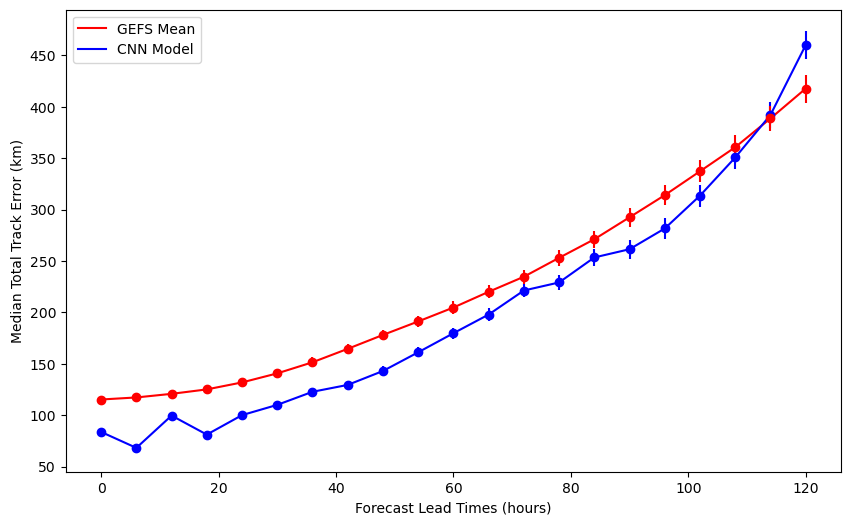

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))

# Calculate means and standard deviations
med_mod = df_mod_dists.describe().loc['50%']
std_mod = df_mod_dists.std()

med_ens = df_ens_dists.describe().loc['50%']
std_ens = df_ens_dists.std()

# Calculate 95% confidence interval
conf_int_mod = 1.96 * (std_mod / np.sqrt(len(df_mod_dists)))
conf_int_ens = 1.96 * (std_ens / np.sqrt(len(df_ens_dists)))

# Plot with error bars
plt.errorbar(med_mod.index, med_mod, yerr=conf_int_mod, fmt='o', color='blue')
plt.errorbar(med_ens.index, med_ens, yerr=conf_int_ens, fmt='o', color='red')

# Plot the lines
plt.plot(df_ens_dists.columns, df_ens_dists.describe().loc['50%'], color='red', label='GEFS Mean')
plt.plot(df_mod_dists.columns, df_mod_dists.describe().loc['50%'], color='blue', label='CNN Model')

# Add labels and legend
plt.xlabel('Forecast Lead Times (hours)')
plt.ylabel('Median Total Track Error (km)')
plt.legend(loc = 'upper left')

# Show the plot
plt.show()

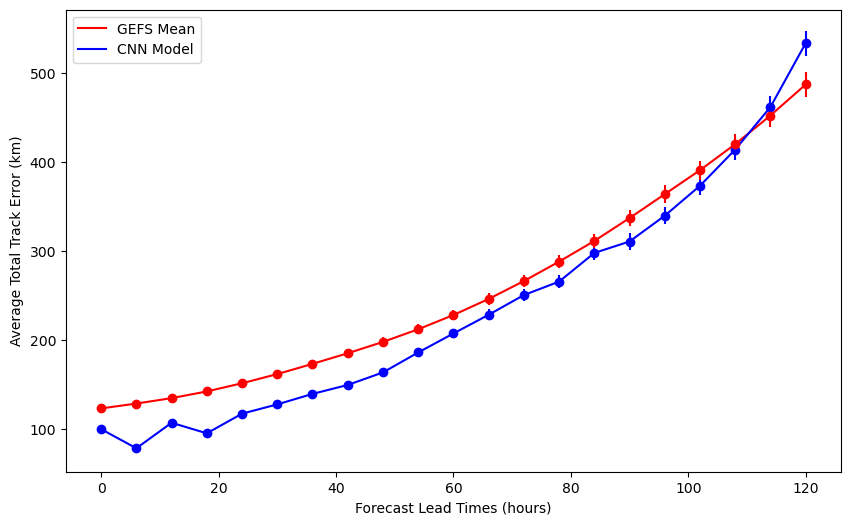

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))

# Calculate means and standard deviations
mean_mod = df_mod_dists.mean()
std_mod = df_mod_dists.std()

mean_ens = df_ens_dists.mean()
std_ens = df_ens_dists.std()

# Calculate 95% confidence interval
conf_int_mod = 1.96 * (std_mod / np.sqrt(len(df_mod_dists)))
conf_int_ens = 1.96 * (std_ens / np.sqrt(len(df_ens_dists)))

# Plot with error bars
plt.errorbar(mean_mod.index, mean_mod, yerr=conf_int_mod, fmt='o', color='blue')
plt.errorbar(mean_ens.index, mean_ens, yerr=conf_int_ens, fmt='o', color='red')

# Plot the lines
plt.plot(df_ens_dists.columns, df_ens_dists.mean(), color='red', label='GEFS Mean')
plt.plot(df_mod_dists.columns, df_mod_dists.mean(), color='blue', label='CNN Model')

# Add labels and legend
plt.xlabel('Forecast Lead Times (hours)')
plt.ylabel('Average Total Track Error (km)')
plt.legend(loc = 'upper left')

# Show the plot
plt.show()

In [34]:
df_mod_dists.describe().loc['50%']

0       83.818700
6       68.323369
12      99.726846
18      81.242750
24     100.171489
30     110.153649
36     122.870435
42     129.564358
48     143.101323
54     161.274475
60     179.819317
66     197.983436
72     221.366210
78     229.197784
84     253.503360
90     261.521856
96     281.689942
102    313.622244
108    350.725737
114    392.075865
120    460.019623
Name: 50%, dtype: float64

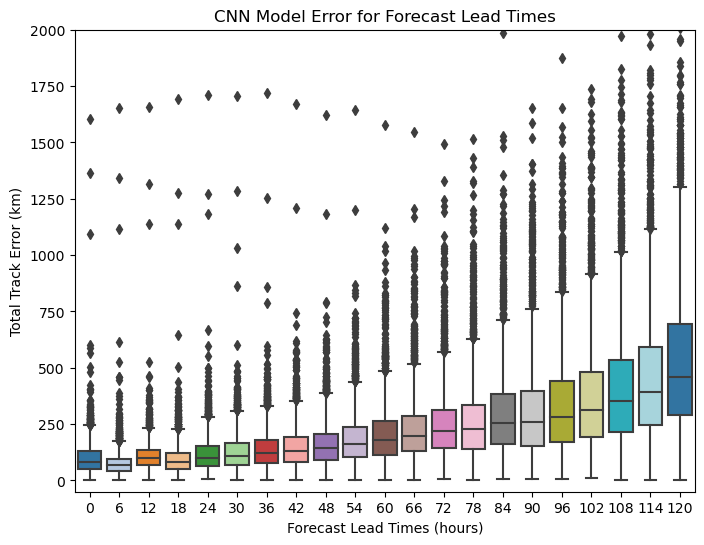

In [35]:
# Create a box plot using Seaborn
plt.figure(figsize=(8, 6))  # Set the figure size (optional)

# You can customize the appearance of the plot using Seaborn's options
custom_palette = sns.color_palette('tab20', 21)
sns.boxplot(data=df_mod_dists, palette=custom_palette)  # 'palette' controls the color palette

# Set labels and title
plt.xlabel('Forecast Lead Times (hours)')
plt.ylabel('Total Track Error (km)')
plt.title('CNN Model Error for Forecast Lead Times')

plt.ylim(-50, 2000)

# Display the plot
plt.show()

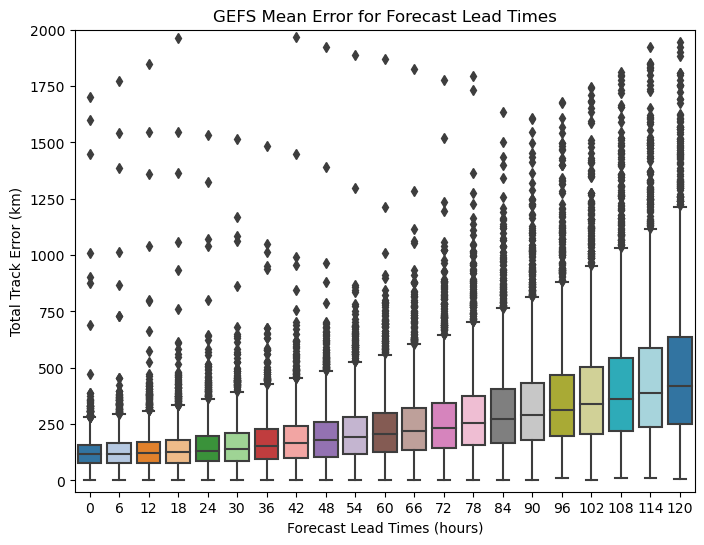

In [36]:
# Create a box plot using Seaborn
plt.figure(figsize=(8, 6))  # Set the figure size (optional)

# You can customize the appearance of the plot using Seaborn's options
custom_palette = sns.color_palette('tab20', 22)
sns.boxplot(data=df_ens_dists, palette=custom_palette)  # 'palette' controls the color palette

# Set labels and title
plt.xlabel('Forecast Lead Times (hours)')
plt.ylabel('Total Track Error (km)')
plt.title('GEFS Mean Error for Forecast Lead Times')

plt.ylim(-50, 2000)

# Display the plot
plt.show()

In [37]:
full_matrix

AC00lat00  AC00lat06  AC00lat12  AC00lat18  \
date                basin CY                                               
2008-07-03 12:00:00 AL    02       12.3       12.8       12.9       13.3   
2008-07-03 18:00:00 AL    02       12.7       13.0       13.4       14.0   
2008-07-04 00:00:00 AL    02       13.1       13.8       14.1       14.6   
2008-07-08 06:00:00 AL    02       20.0       20.3       20.8       21.4   
2008-07-08 12:00:00 AL    02       20.7       21.0       21.6       21.8   
...                                 ...        ...        ...        ...   
2022-09-25 18:00:00 AL    09       15.0       15.8       16.6       17.4   
2022-09-26 00:00:00 AL    09       15.7       16.7       17.6       18.6   
2022-09-26 06:00:00 AL    09       16.8       17.5       18.6       19.6   
2022-09-26 12:00:00 AL    09       17.8       18.6       19.7       20.7   
2022-11-06 18:00:00 AL    17       20.8       22.7       23.8       25.0   

                              AC00lat24  AC00lat30  AC00lat36  AC00lat42  \
date                basin CY                                               
2008-07-03 12:00:00 AL    02       13.9       14.2       15.0       15.3   
2008-07-03 18:00:00 AL    02       14.0       14.9       15.2       15.6   
2008-07-04 00:00:00 AL    02       15.1       15.7       16.0       16.4   
2008-07-08 06:00:00 AL    02       21.8       22.2       22.7       23.0   
2008-07-08 12:00:00 AL    02       22.5       23.0       23.2       24.0   
...                                 ...        ...        ...        ...   
2022-09-25 18:00:00 AL    09       18.2       19.4       20.4       21.3   
2022-09-26 00:00:00 AL    09       19.8       20.8       21.7       22.8   
2022-09-26 06:00:00 AL    09       20.6       21.6       22.5       23.4   
2022-09-26 12:00:00 AL    09       22.0       22.8       23.7       24.6   
2022-11-06 18:00:00 AL    17       24.4       25.3       26.5       27.5   

                              AC00lat48  AC00lat54  AC00lat60  AC00lat66  \
date                basin CY                                               
2008-07-03 12:00:00 AL    02       15.7       16.3       16.9       17.5   
2008-07-03 18:00:00 AL    02       16.0       16.2       16.8       16.9   
2008-07-04 00:00:00 AL    02       16.8       16.9       17.2       17.7   
2008-07-08 06:00:00 AL    02       23.5       24.5       24.2       24.2   
2008-07-08 12:00:00 AL    02       24.1       25.2       25.8       26.2   
...                                 ...        ...        ...        ...   
2022-09-25 18:00:00 AL    09       22.4       23.4       24.4       25.3   
2022-09-26 00:00:00 AL    09       23.7       24.6       25.5       26.3   
2022-09-26 06:00:00 AL    09       24.3       25.1       25.9       26.5   
2022-09-26 12:00:00 AL    09       25.3       26.2       26.7       27.2   
2022-11-06 18:00:00 AL    17       28.2       28.3       28.1       27.3   

                              AC00lat72  AC00lat78  AC00lat84  AC00lat90  \
date                basin CY                                               
2008-07-03 12:00:00 AL    02       17.7       18.0       18.8       19.1   
2008-07-03 18:00:00 AL    02       17.8       17.8       18.3       18.9   
2008-07-04 00:00:00 AL    02       18.2       18.7       19.0       19.8   
2008-07-08 06:00:00 AL    02       24.2       24.2       24.2       24.2   
2008-07-08 12:00:00 AL    02       26.2       26.9       28.1       28.2   
...                                 ...        ...        ...        ...   
2022-09-25 18:00:00 AL    09       26.2       27.0       27.6       28.1   
2022-09-26 00:00:00 AL    09       27.1       27.5       27.7       28.1   
2022-09-26 06:00:00 AL    09       27.0       27.3       27.7       28.3   
2022-09-26 12:00:00 AL    09       27.3       27.8       27.9       28.4   
2022-11-06 18:00:00 AL    17       26.6       26.3       26.7       26.9   

                              AC00lat96  AC00lat102  AC00lat108  AC00lat11

In [38]:
_df = df_mod_dists - df_ens_dists
_df

0           6           12          18   \
date                basin CY                                                   
2008-07-03 12:00:00 AL    02 -110.267753 -153.664840 -157.994897 -124.558275   
2008-07-03 18:00:00 AL    02 -139.052640 -163.463855  -67.802160  -13.459923   
2008-07-04 00:00:00 AL    02  -97.824109  -91.843834   -3.890483    6.486081   
2008-07-08 06:00:00 AL    02   82.834849  101.182720   99.820584   41.583393   
2008-07-08 12:00:00 AL    02   80.504425  103.286410  108.948549    6.306290   
...                                  ...         ...         ...         ...   
2022-09-25 18:00:00 AL    09  -81.604337  -69.262527   -8.772076 -106.476072   
2022-09-26 00:00:00 AL    09  -94.686010 -133.854589  -29.844517  -82.886603   
2022-09-26 06:00:00 AL    09  -70.996558 -108.263564  -19.023231  -95.778751   
2022-09-26 12:00:00 AL    09  -30.154146 -105.859875  -11.974944  -73.225478   
2022-11-06 18:00:00 AL    17  -83.648442  -28.095348   75.369383  -66.487722   

                                    24         30          36          42   \
date                basin CY                                                 
2008-07-03 12:00:00 AL    02 -54.402750 -63.144865 -124.242818 -121.985052   
2008-07-03 18:00:00 AL    02   5.035403  14.984883  -41.990834  -76.099463   
2008-07-04 00:00:00 AL    02  42.965321  52.840951  -11.333994  -35.534876   
2008-07-08 06:00:00 AL    02  58.139674  21.253023  -78.017689  -62.757840   
2008-07-08 12:00:00 AL    02  45.077889  14.465501  -70.821933  -81.953064   
...                                 ...        ...         ...         ...   
2022-09-25 18:00:00 AL    09 -69.711408 -45.988657  -88.454253 -122.721294   
2022-09-26 00:00:00 AL    09 -18.996680 -14.624697  -54.415259  -75.980619   
2022-09-26 06:00:00 AL    09   7.019568  -3.145627  -94.494135  -61.499121   
2022-09-26 12:00:00 AL    09  16.831104 -41.212302 -107.102893  -72.210470   
2022-11-06 18:00:00 AL    17   9.068923 -23.202065  -45.378915  -21.528100   

                                     48          54          60          66   \
date                basin CY                                                   
2008-07-03 12:00:00 AL    02 -142.729822 -207.438534 -190.627851 -209.950285   
2008-07-03 18:00:00 AL    02  -93.197028 -164.886356 -204.154756 -139.928739   
2008-07-04 00:00:00 AL    02  -66.824328 -156.034242 -170.373475  -49.893488   
2008-07-08 06:00:00 AL    02  -52.255355  -51.953672  -20.203469   86.617956   
2008-07-08 12:00:00 AL    02  -30.968622  -53.864592  -26.638711   85.277891   
...                                  ...         ...         ...         ...   
2022-09-25 18:00:00 AL    09  -57.996149 -106.564941  -32.244114  -58.834123   
2022-09-26 00:00:00 AL    09  -41.333486  -73.147359   -6.190444  -31.157959   
2022-09-26 06:00:00 AL    09   -8.324435  -76.490100  -22.984181  -59.128993   
2022-09-26 12:00:00 AL    09  -42.121939 -110.236697  -60.176249 -116.076433   
2022-11-06 18:00:00 AL    17  -43.593621  -73.449888 -126.602381  -78.252179   

                                     72          78          84          90   \
date                basin CY                                                   
2008-07-03 12:00:00 AL    02 -199.716311 -129.676637 -125.311466 -136.254923   
2008-07-03 18:00:00 AL    02 -141.912887 -181.817147  -85.058729  -95.164596   
2008-07-04 00:00:00 AL    02 -107.902742 -127.243300  -19.789622   74.570300   
2008-07-08 06:00:00 AL    02   76.985908   49.848610  152.363266  186.508583   
2008-07-08 12:00:00 AL    02   13.251733   23.623038  143.989119   99.911212   
...                                  ...         ...         ...         ...   
2022-09-25 18:00:00 AL    09  -93.232968  -85.273186   35.335209   65.732022   
2022-09-26 00:00:00 AL    09  -70.488644  -43.920726   63.924802   67.722235   
2022-09-26 06:00:00 AL    09  -82.303400  -79.283882   20.324260   39.376992   
2022-09-26 12:00:00 AL    09 -151.013325 -139.726852  -58.01

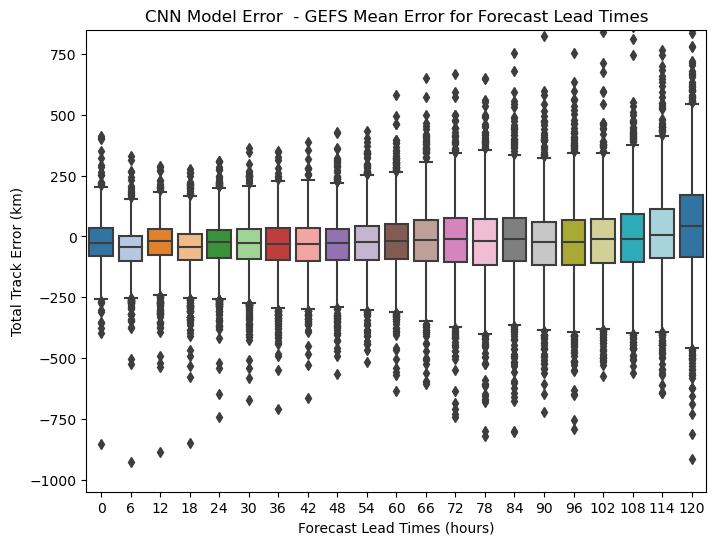

In [39]:
# Create a box plot using Seaborn
plt.figure(figsize=(8, 6))  # Set the figure size (optional)

# You can customize the appearance of the plot using Seaborn's options
custom_palette = sns.color_palette('tab20', 21)
sns.boxplot(data=_df, palette=custom_palette)  # 'palette' controls the color palette

# Set labels and title
plt.xlabel('Forecast Lead Times (hours)')
plt.ylabel('Total Track Error (km)')
plt.title('CNN Model Error  - GEFS Mean Error for Forecast Lead Times')

plt.ylim(-1050, 850)

# Display the plot
plt.show()

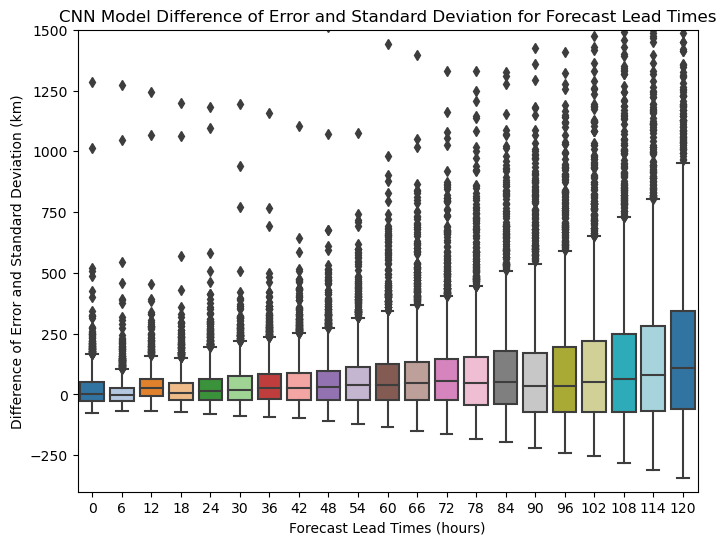

In [40]:
# Create a box plot using Seaborn
plt.figure(figsize=(8, 6))  # Set the figure size (optional)

# You can customize the appearance of the plot using Seaborn's options
custom_palette = sns.color_palette('tab20', 21)
sns.boxplot(data=df_mod_dist_std, palette=custom_palette)  # 'palette' controls the color palette

# Set labels and title
plt.xlabel('Forecast Lead Times (hours)')
plt.ylabel('Difference of Error and Standard Deviation (km)')
plt.title('CNN Model Difference of Error and Standard Deviation for Forecast Lead Times')

plt.ylim(-400, 1500)

# Display the plot
plt.show()

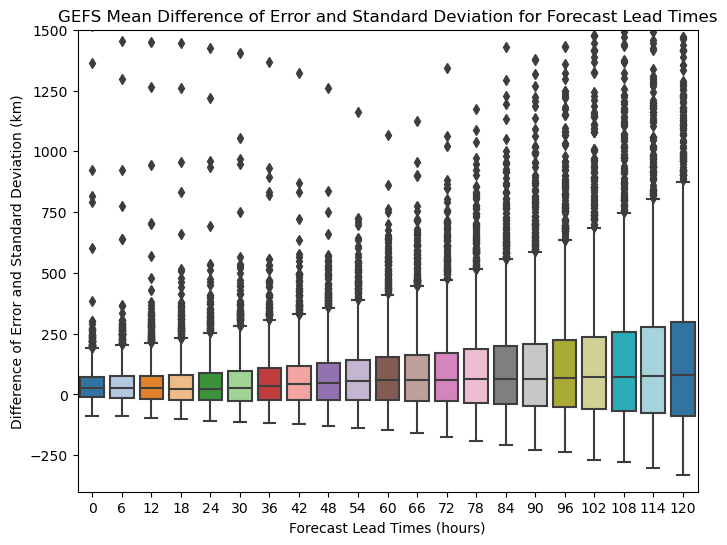

In [41]:
# Create a box plot using Seaborn
plt.figure(figsize=(8, 6))  # Set the figure size (optional)

# You can customize the appearance of the plot using Seaborn's options
custom_palette = sns.color_palette('tab20', 21)
sns.boxplot(data=df_ens_dist_std, palette=custom_palette)  # 'palette' controls the color palette

# Set labels and title
plt.xlabel('Forecast Lead Times (hours)')
plt.ylabel('Difference of Error and Standard Deviation (km)')
plt.title('GEFS Mean Difference of Error and Standard Deviation for Forecast Lead Times')

plt.ylim(-400, 1500)

# Display the plot
plt.show()

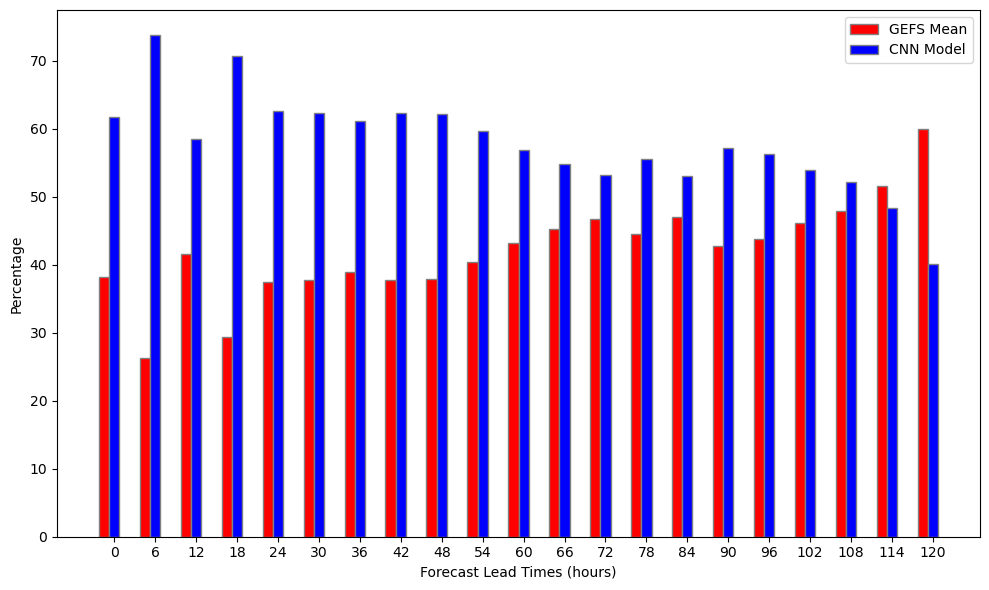

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

taus = []
for i in range (0, NUM_OF_INTERVALS):
    taus.append(i*6)

df_percent = pd.DataFrame(count).T
df_percent.columns = taus

percent_gefs = (df_percent == -1).mean() * 100
#percent_comparable = (df_percent == 0).mean() * 100
percent_cnnlstm = (df_percent == 1).mean() * 100

# Create the double bar graph using matplotlib
plt.figure(figsize=(10, 6))

# Bar positions
bar_width = 0.25
r1 = range(len(percent_gefs))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bars
plt.bar(r1, percent_gefs, color='r', width=bar_width, edgecolor='grey', label='GEFS Mean')
plt.bar(r2, percent_cnnlstm, color='b', width=bar_width, edgecolor='grey', label='CNN Model')
#plt.bar(r3, percent_comparable, color='g', width=bar_width, edgecolor='grey', label='Within 10% of each other')

# Add labels, title, and legend
plt.ylabel('Percentage')
plt.xlabel('Forecast Lead Times (hours)')
plt.xticks([r + bar_width for r in range(len(percent_gefs))], percent_gefs.index)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Display the graph
plt.tight_layout()
plt.show()

In [43]:
percent_gefs.mean()

42.09165921065711

In [44]:
percent_cnnlstm.mean()

57.90834078934288

In [45]:
# Count the number of True values in each row
df_percent['num_true'] = df_percent.apply(lambda row: row.sum(), axis=1)

# Find the row with the most True values
max_true_row = df_percent[df_percent['num_true'] >= df_percent['num_true'].max()]
min_true_row = df_percent[df_percent['num_true'] <= df_percent['num_true'].min()]

In [46]:
np.unique(np.array(count).flatten(), return_counts=True)

(array([-1,  1]), array([21170, 29125], dtype=int64))

In [47]:
improvement = []
for i in test.reset_index().index:
    improvement.append(Compare.compare_closeness(i, test, outputs, NUM_OF_INTERVALS, _print=False))
test['improvement'] = improvement
test1 = test.reset_index()

In [48]:
#filtered_indices = test1.index[(test1['improvement'] > 0.65) & (test1['improvement'] < 0.7)].tolist()
#filtered_indices

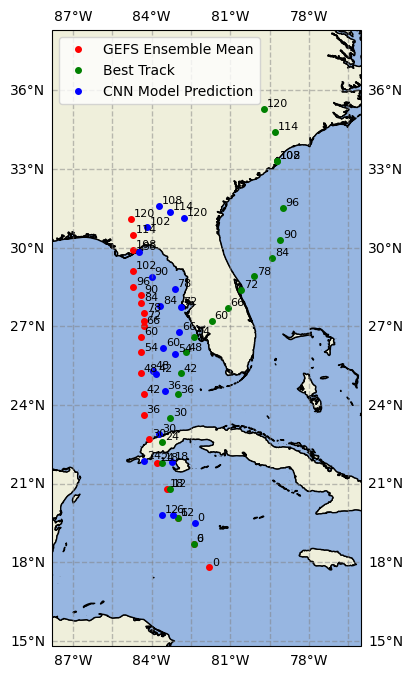

Correlation between mod_ATE and mod_TTE: -0.13438377806958357
Correlation between mod_CTE and mod_TTE: -0.8296348691052999
Correlation between ens_ATE and ens_TTE: 0.019479024552467365
Correlation between ens_CTE and ens_TTE: -0.8146725441027484


C:\Users\nagra\Compare.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_selected = df_selected.append(new_row_df)
C:\Users\nagra\Compare.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_row[-6:-2] *= -1


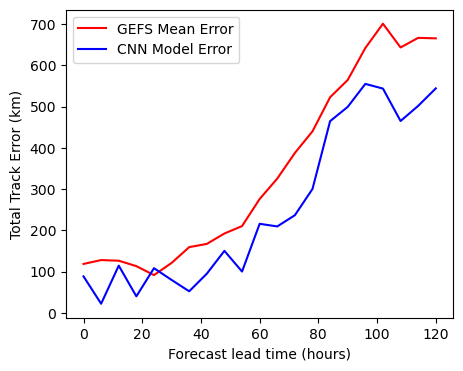

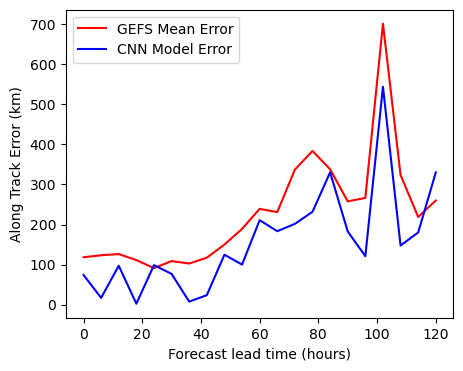

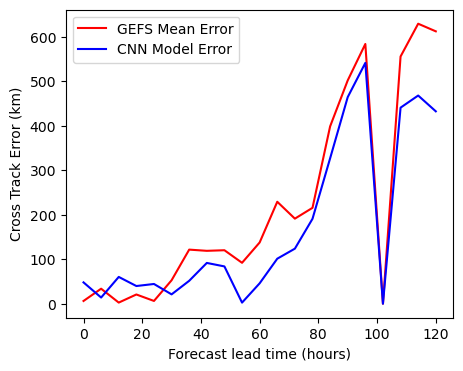

Mean Track RMSE: 2.896467470820933
Model 1 Track RMSE: 2.2782027555232878
Storm Date: (Timestamp('2022-09-26 12:00:00'), '09')
Improvement: 0.2134547415174019


0.2134547415174019

In [49]:
start_num = 2393 #filtered_indices[1]
b = Compare.create_dataframe(start_num, test, outputs, NUM_OF_INTERVALS)
Compare.plot_compare(b, extent=3, position = "upper left")
Compare.error_graph(b, (5,4))
Compare.compare_closeness(start_num, test, outputs, NUM_OF_INTERVALS, _print = True)


 hour 0:


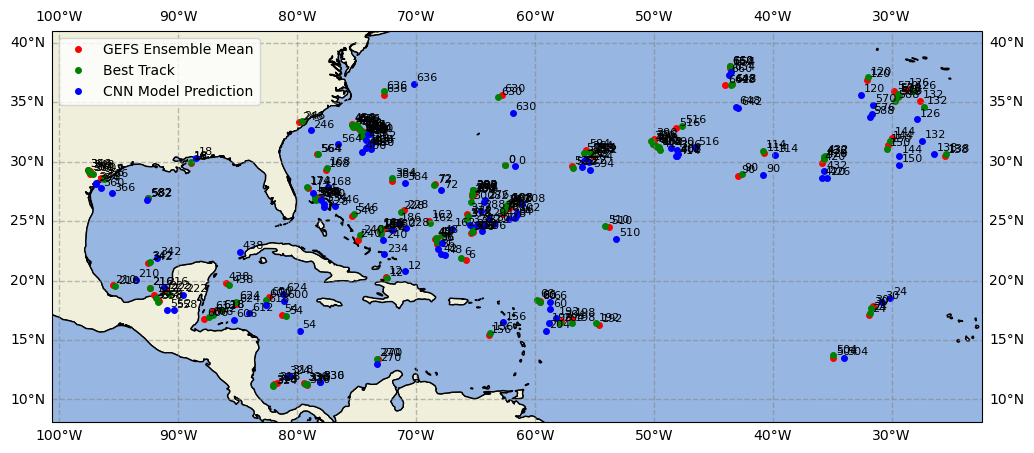


 hour 6:


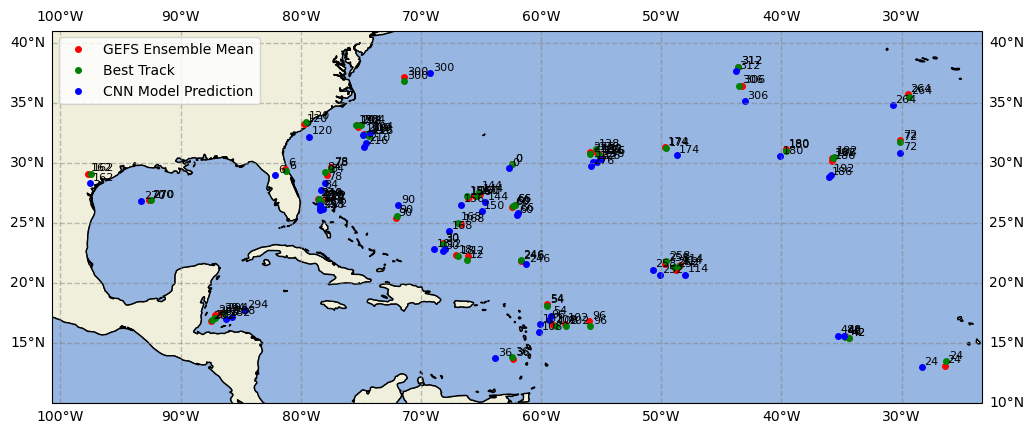


 hour 12:


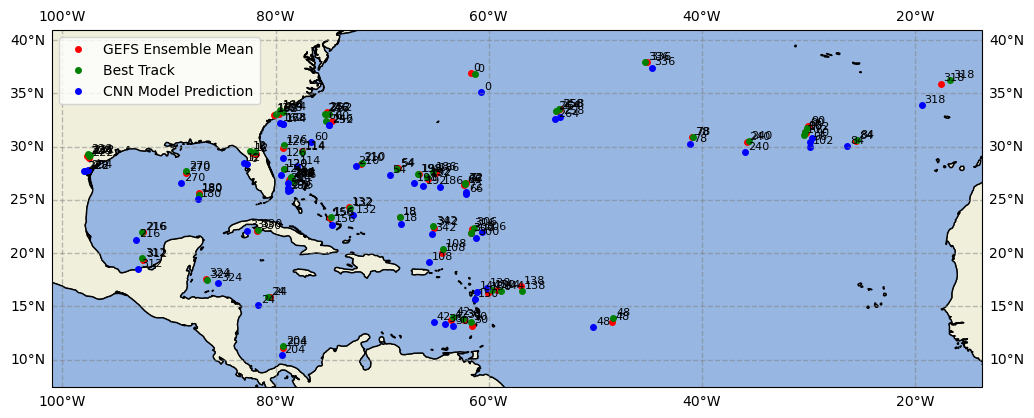


 hour 18:


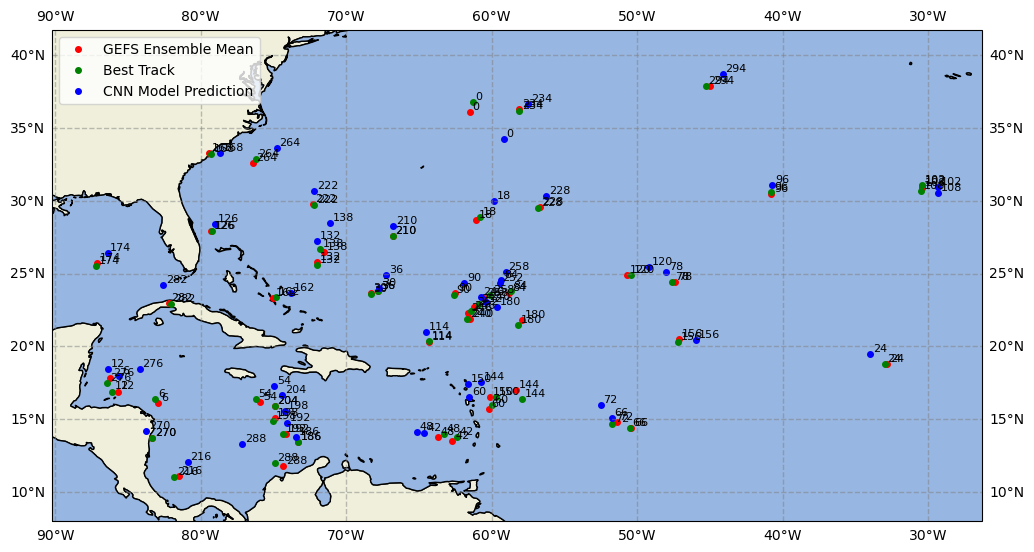


 hour 24:


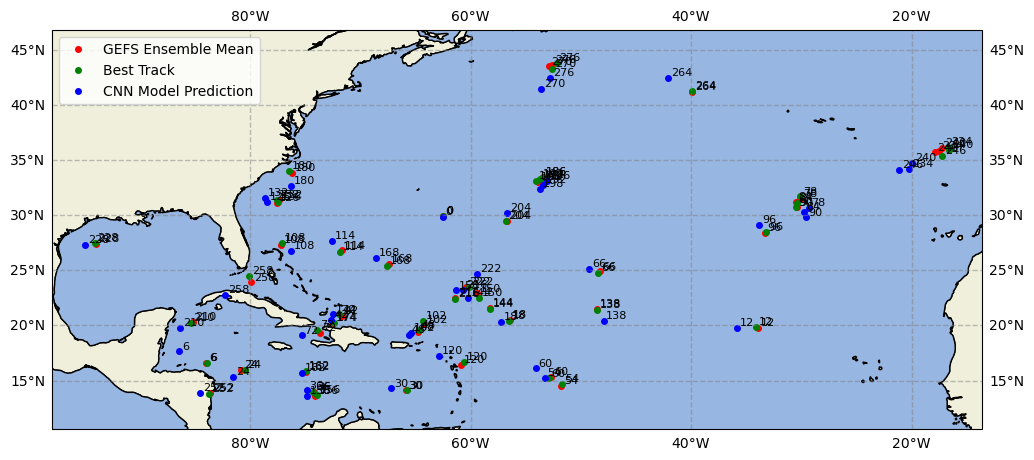


 hour 30:


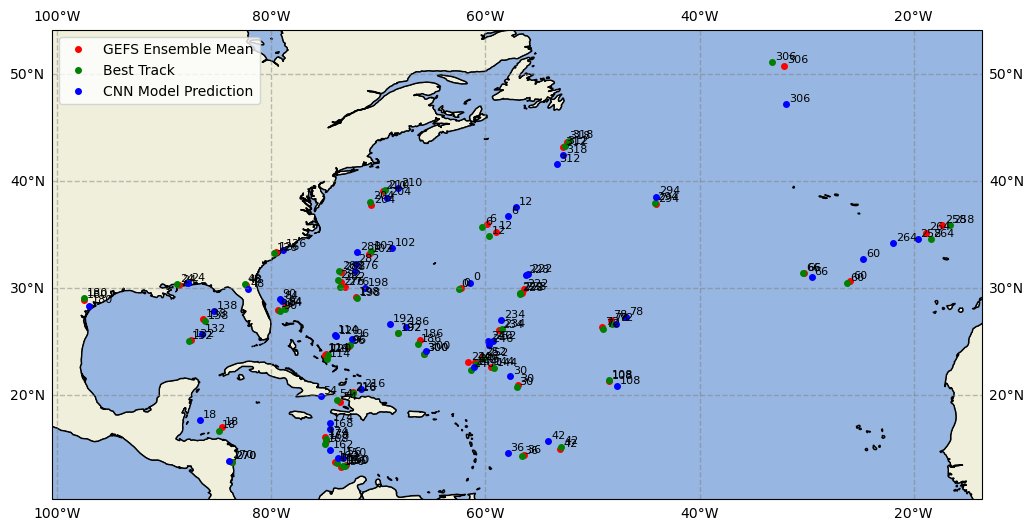


 hour 36:


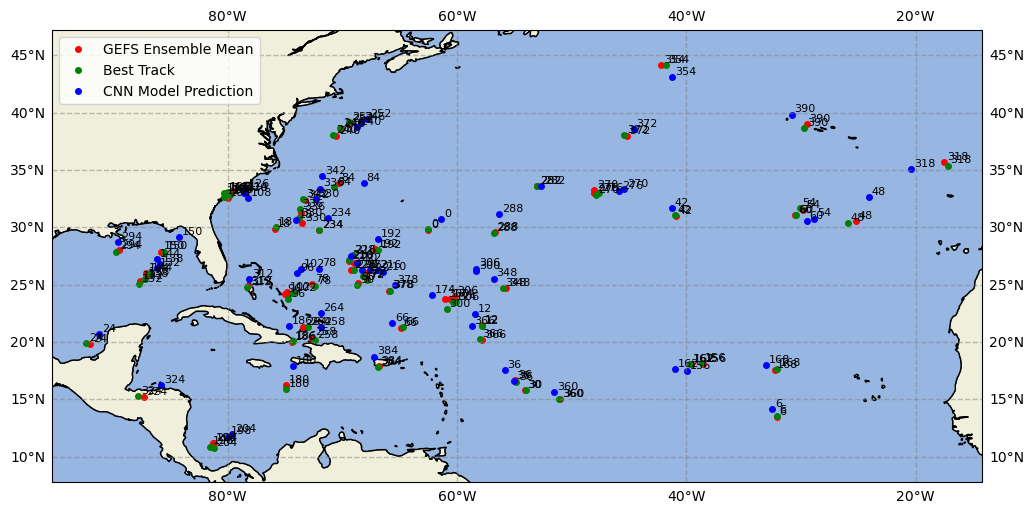


 hour 42:


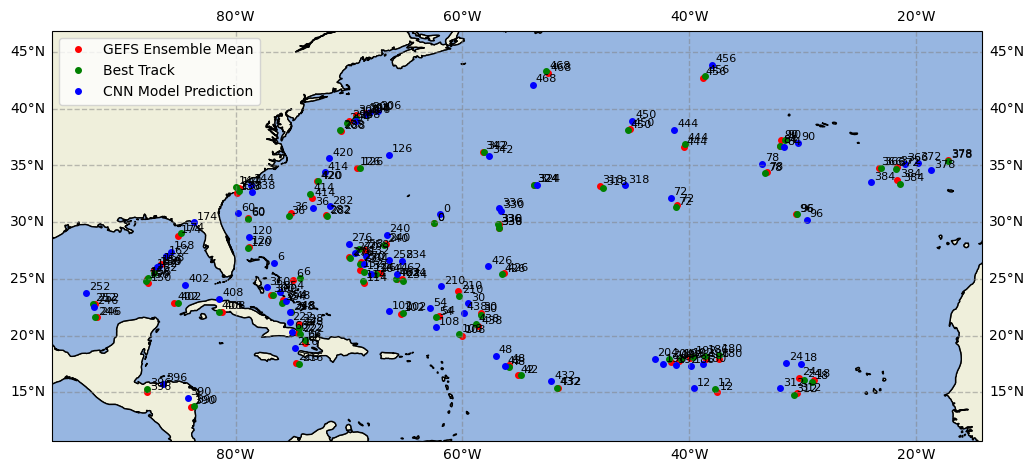


 hour 48:


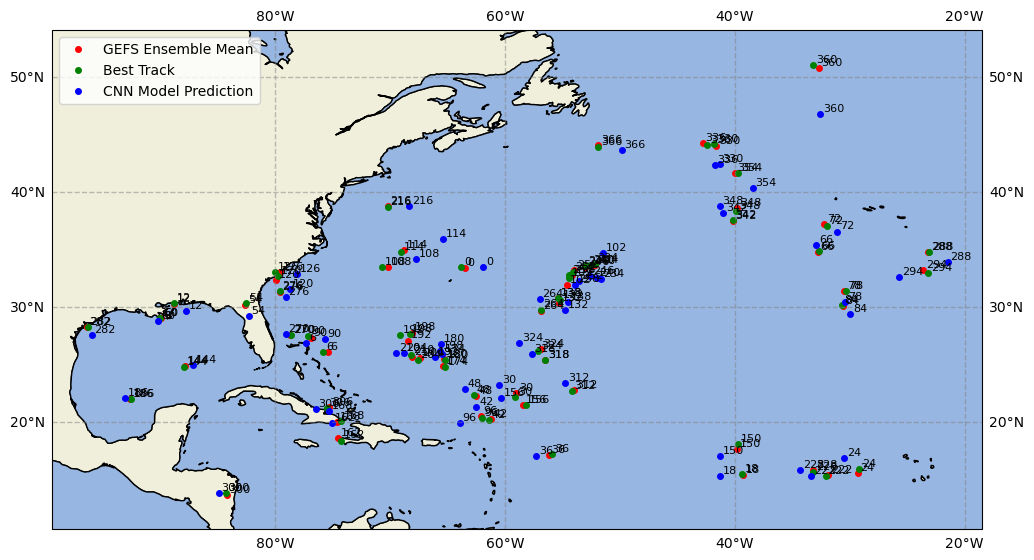


 hour 54:


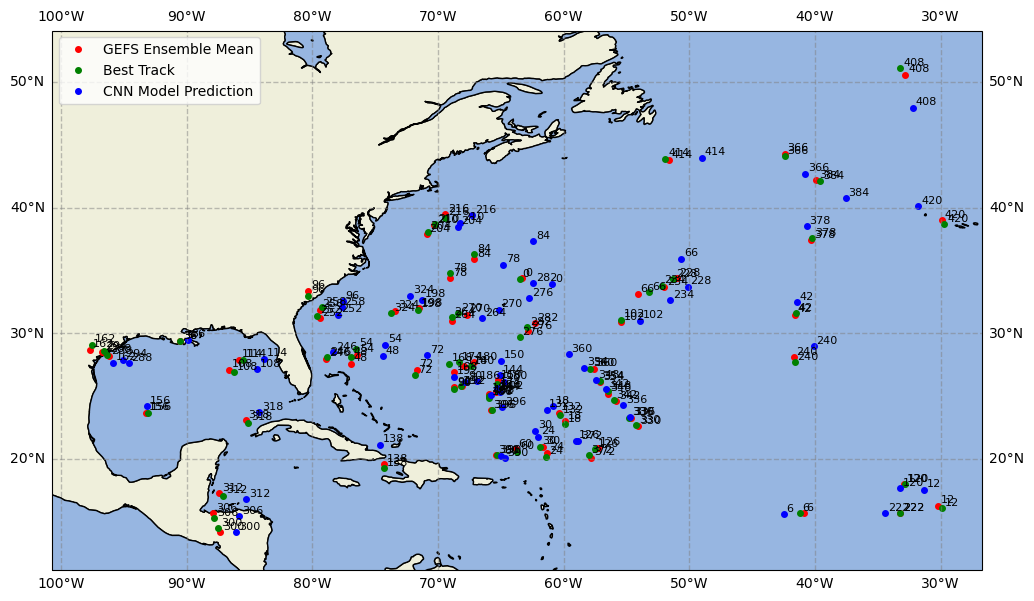


 hour 60:


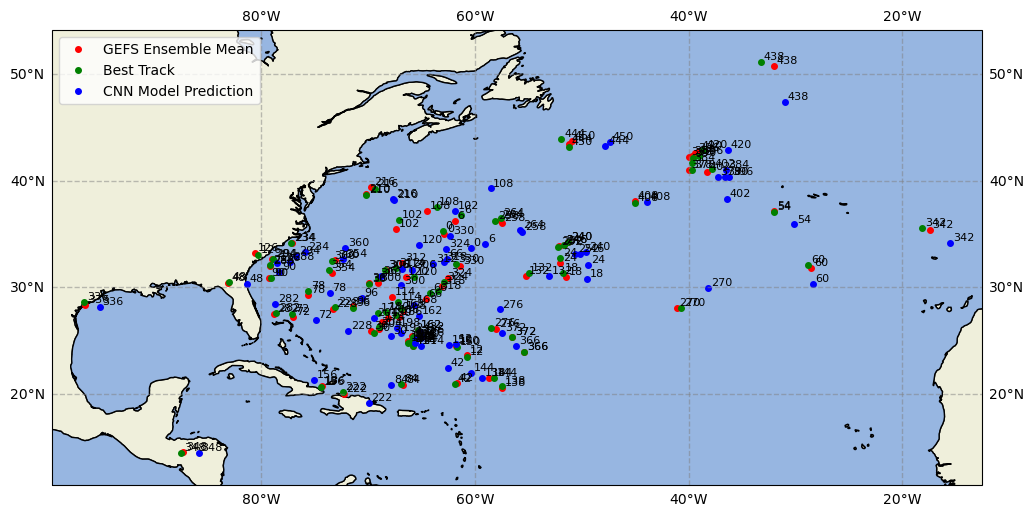


 hour 66:


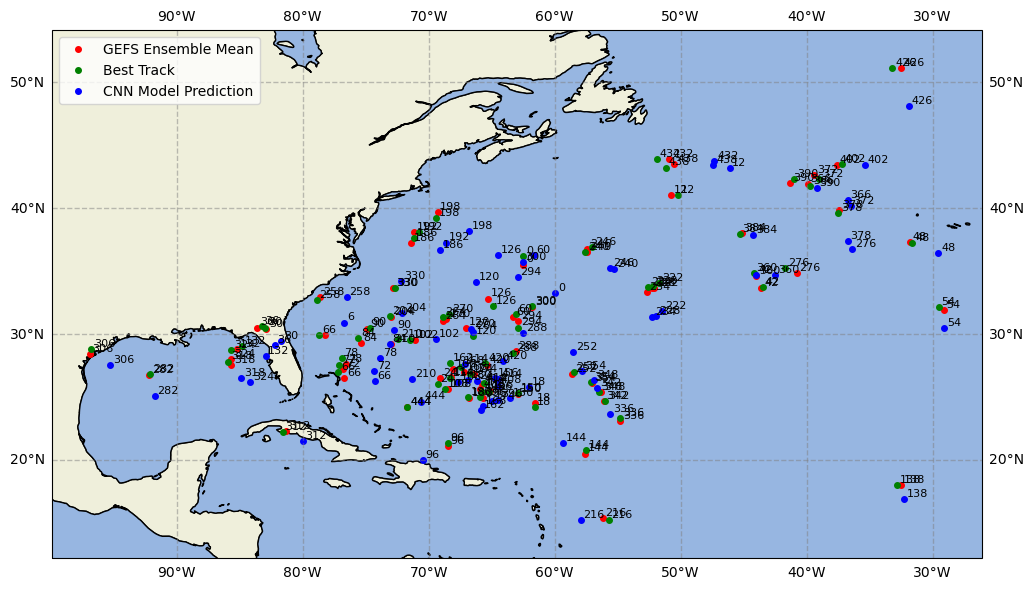


 hour 72:


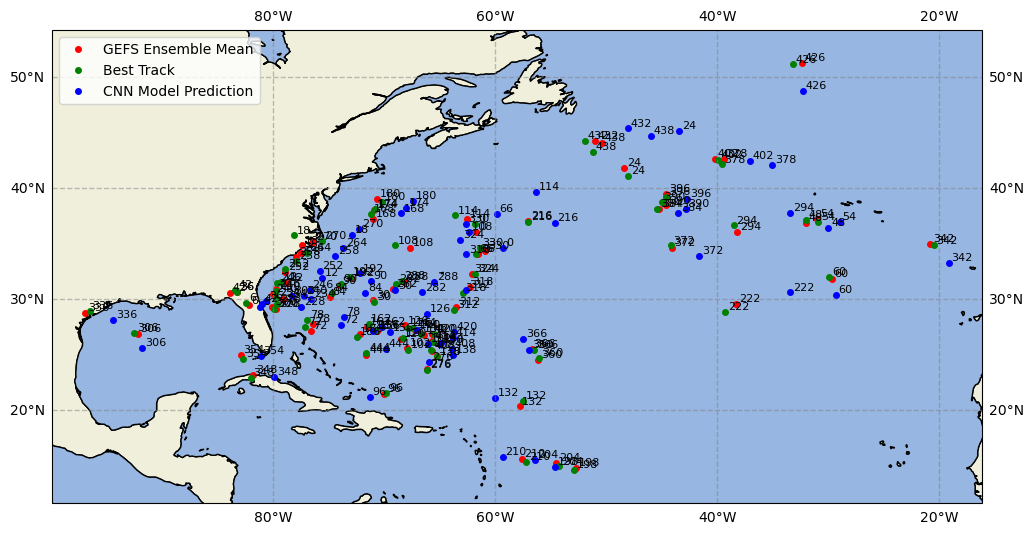


 hour 78:


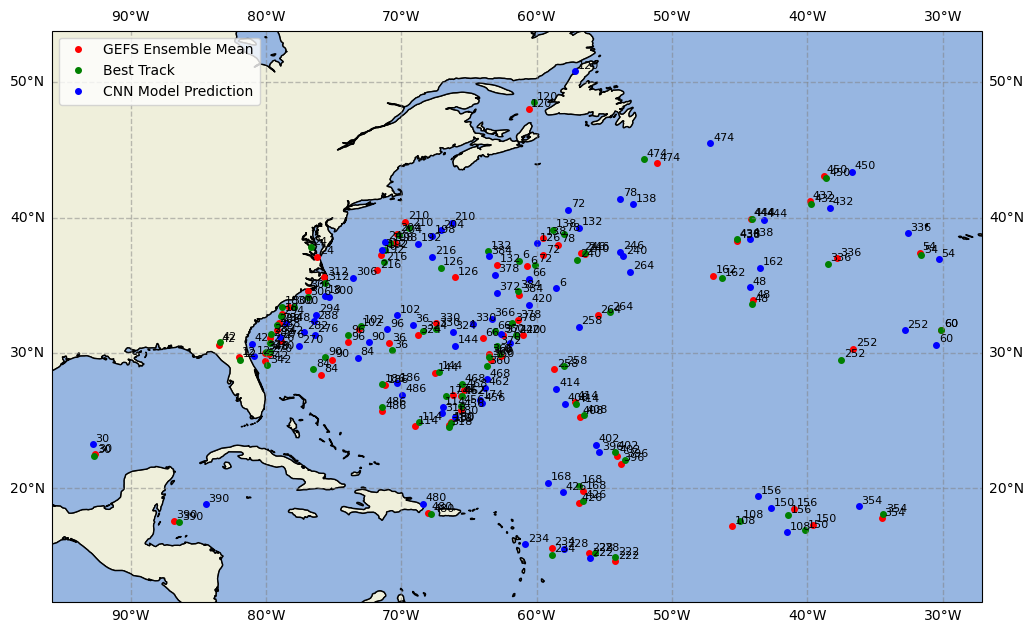


 hour 84:


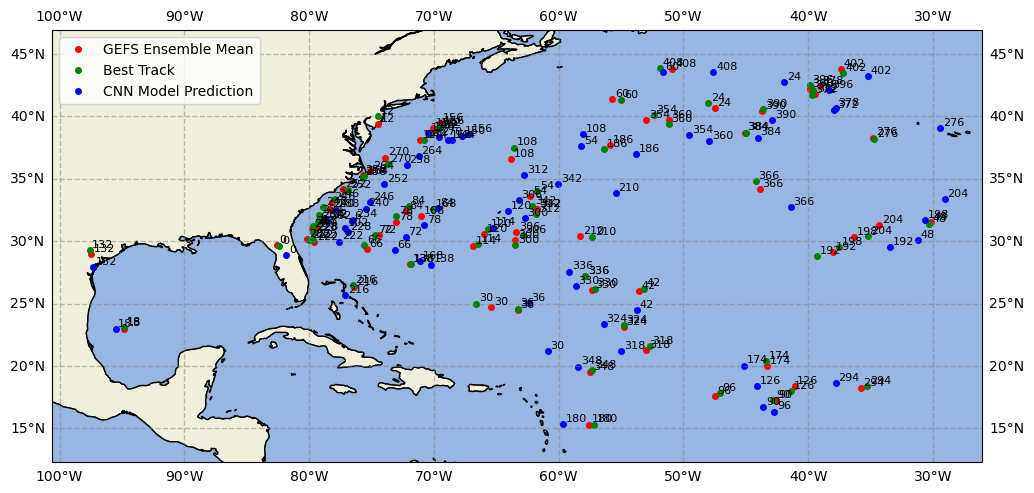


 hour 90:


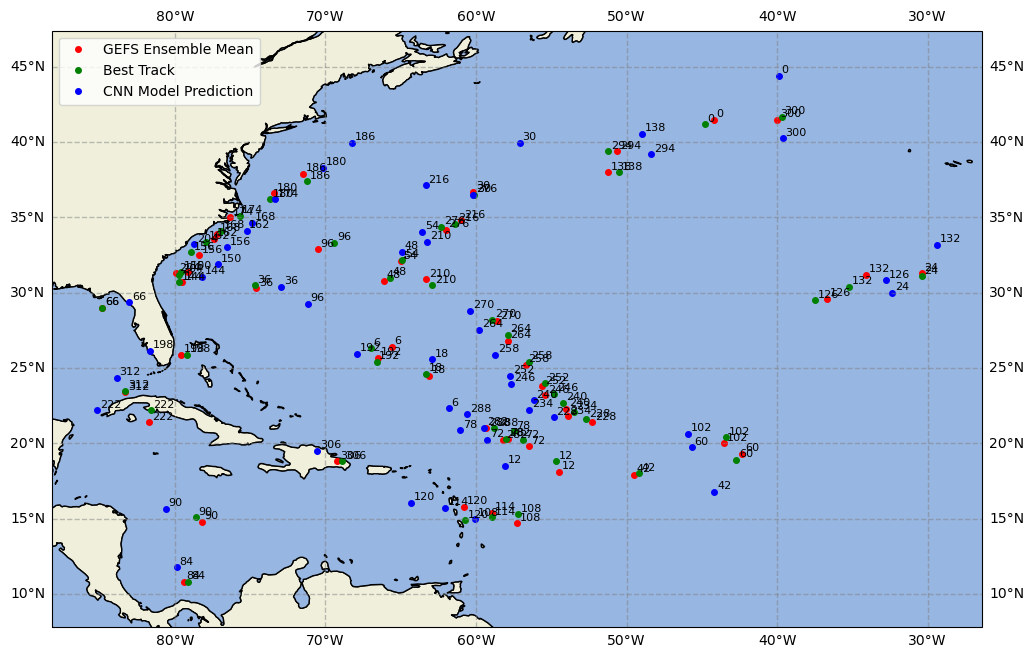


 hour 96:


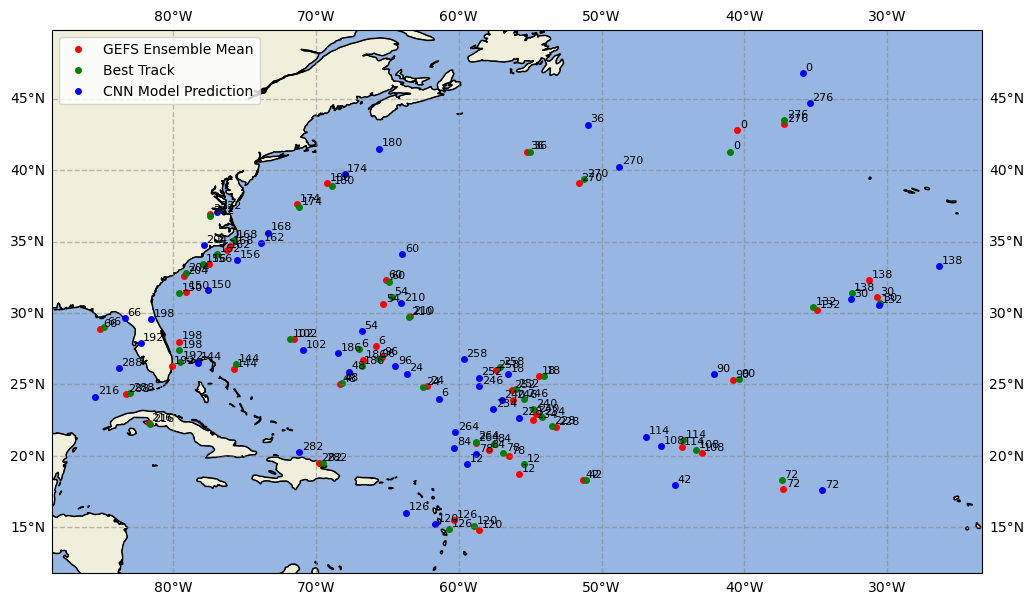


 hour 102:


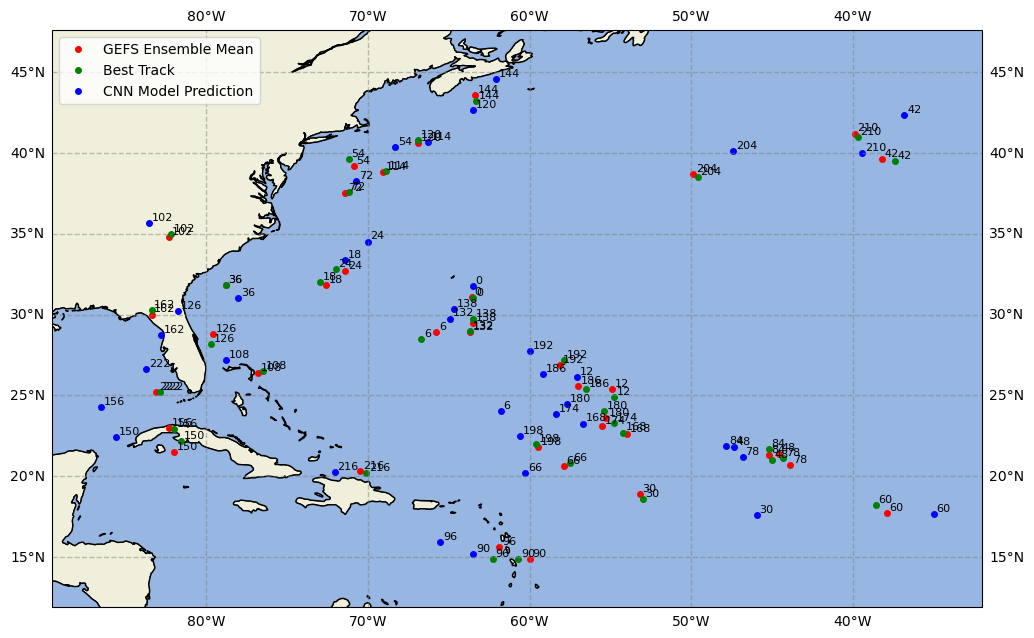


 hour 108:


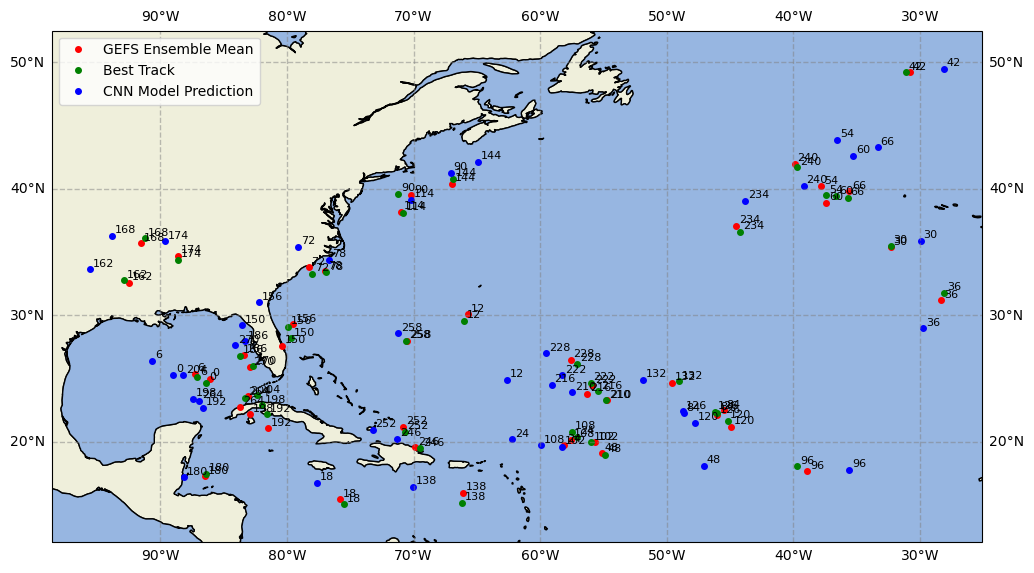


 hour 114:


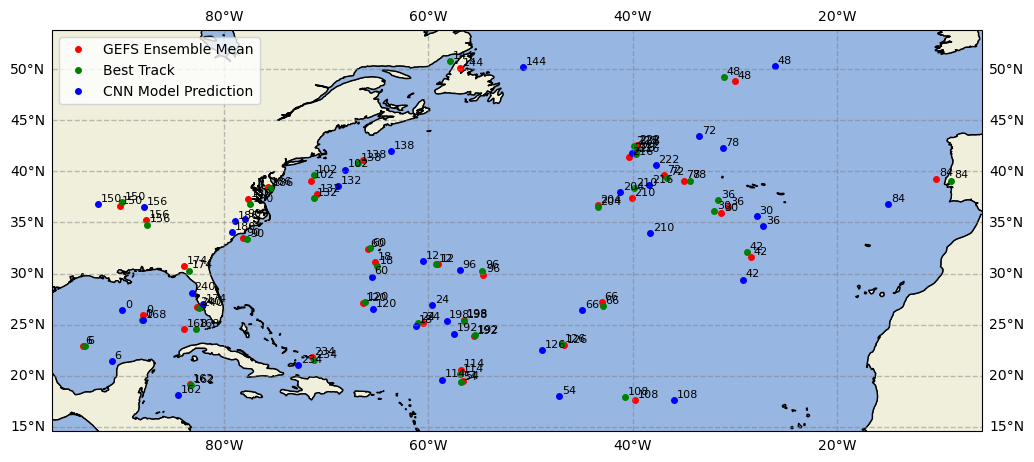


 hour 120:


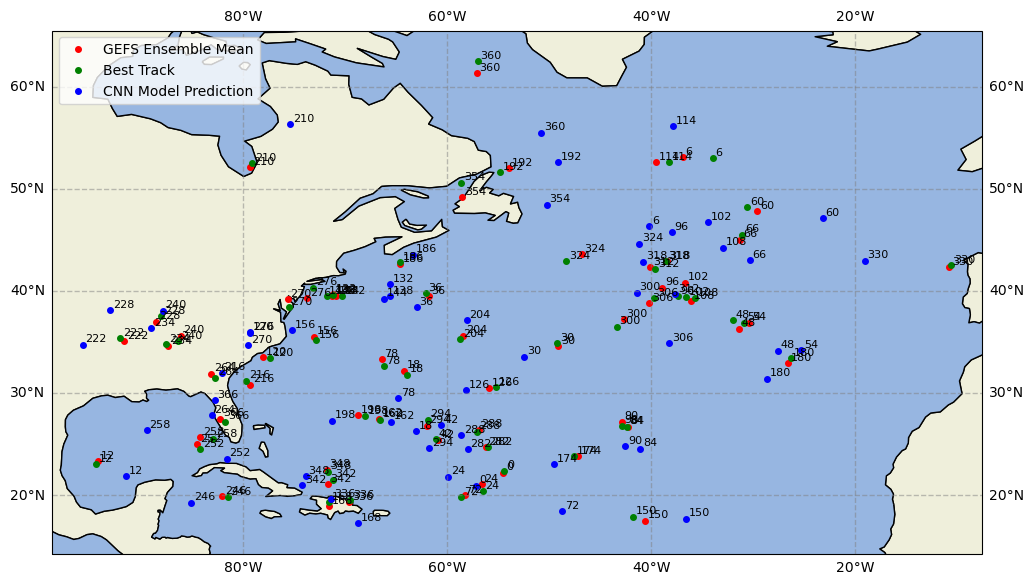

In [50]:
for hour in range(0, 126, 6):
    print("\n hour " + str(hour) + ":")
    i = int(hour/6)
    a = full_matrix.loc[df_ens_dists[df_ens_dists.iloc[:, i] * 4 < df_mod_dists.iloc[:, i]].iloc[:, i].index]
    c = ((120-hour)/6 + 1) * (-2)
    a = a.iloc[:, [c-42-21-i-21, c-42-21-i, c-42, c-42+1, c, c+1]]

    a.columns = ['mlat', 'mlon', 'blat', 'blon', 'plat', 'plon']
    a = a.reset_index()
    a = a.drop("basin", axis = 1)
    a.set_index(["date", "CY"], inplace=True)

    Compare.plot_compare(a, extent=3, position = "upper left")